In [24]:
import cv2
import numpy as np
import os
import random
from tqdm.auto import tqdm
import time
TRAIN_DIR = "./dogs-vs-cats/train/train"
TEST_DIR = "./dogs-vs-cats/train/train"
IMG_SIZE = 64
LR=1e-3
MODEL_NAME=f"dogs-vs-cats-conv-{LR}-{IMG_SIZE}"


Next we will make a function to label the images, and it returns an array where the first element is the probability it is a cat, and the second element is the probability it is a dog.

In [25]:
def label_image(path : str):
    if "cat" in path: return [1,0] # Cat
    return [0,1] # Dog

In [26]:
def create_train_data():
    if (input("Are you sure you want to reshuffle training data?")!="y"): return
    
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label=label_image(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
        
        training_data.append([np.array(img),np.array(label)])
        
    random.shuffle(training_data)
    np.save(f'train_data.npy',np.array(training_data,dtype=object))
    return training_data

In [27]:
def create_test_data():
    if (input("Are you sure you want to reshuffle testing data?")!="y"): return
    
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
        
        testing_data.append([np.array(img),img_num])
    random.shuffle(testing_data)
    np.save(f'test_data.npy',np.array(testing_data,dtype=object))
    return testing_data

In [28]:
train_data = create_train_data()
a = 5
print("Hello world")

100%|██████████| 25000/25000 [00:14<00:00, 1733.33it/s]


Hello world


In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

model = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1), name="input"),

    layers.Conv2D(32, kernel_size=(2, 2), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, kernel_size=(2, 2), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),

    layers.Dense(1024, activation="relu"),
    layers.Dropout(0.2),

    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=LR),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 63, 63, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 30, 30, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │    14,746,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,756,065 (56.29 MB)

 Trainable params: 14,756,065 (56.29 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
X = np.array([i[0] for i in train_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array([i[1][1] for i in train_data])  # dog = 1, cat = 0

X = X / 255.0  # normalize

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42
)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val)
)


Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 68s 95ms/step - accuracy: 0.6950 - loss: 0.5756 - val_accuracy: 0.7668 - val_loss: 0.5021
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 67s 95ms/step - accuracy: 0.7696 - loss: 0.4790 - val_accuracy: 0.7728 - val_loss: 0.4730
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 67s 95ms/step - accuracy: 0.8060 - loss: 0.4232 - val_accuracy: 0.7788 - val_loss: 0.4748
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 67s 96ms/step - accuracy: 0.8320 - loss: 0.3693 - val_accuracy: 0.7696 - val_loss: 0.4857
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 67s 95ms/step - accuracy: 0.8660 - loss: 0.3109 - val_accuracy: 0.7932 - val_loss: 0.4630
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 67s 96ms/step - accuracy: 0.9044 - loss: 0.2310 - val_accuracy: 0.7976 - val_loss: 0.5045
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 67s 95ms/step - accuracy: 0.9387 - loss: 0.1562 - val_accuracy: 0.7804 - val_loss: 0.5840
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 67s 96ms/step - accuracy: 0.9645 - loss: 0.0993 - 

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7872 - loss: 0.8715
Validation accuracy: 0.7872


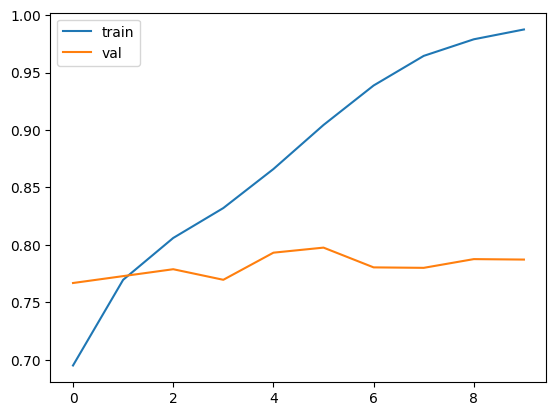

In [31]:
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation accuracy: {val_acc:.4f}")

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show() 

100%|██████████| 25000/25000 [00:15<00:00, 1613.86it/s]


782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step


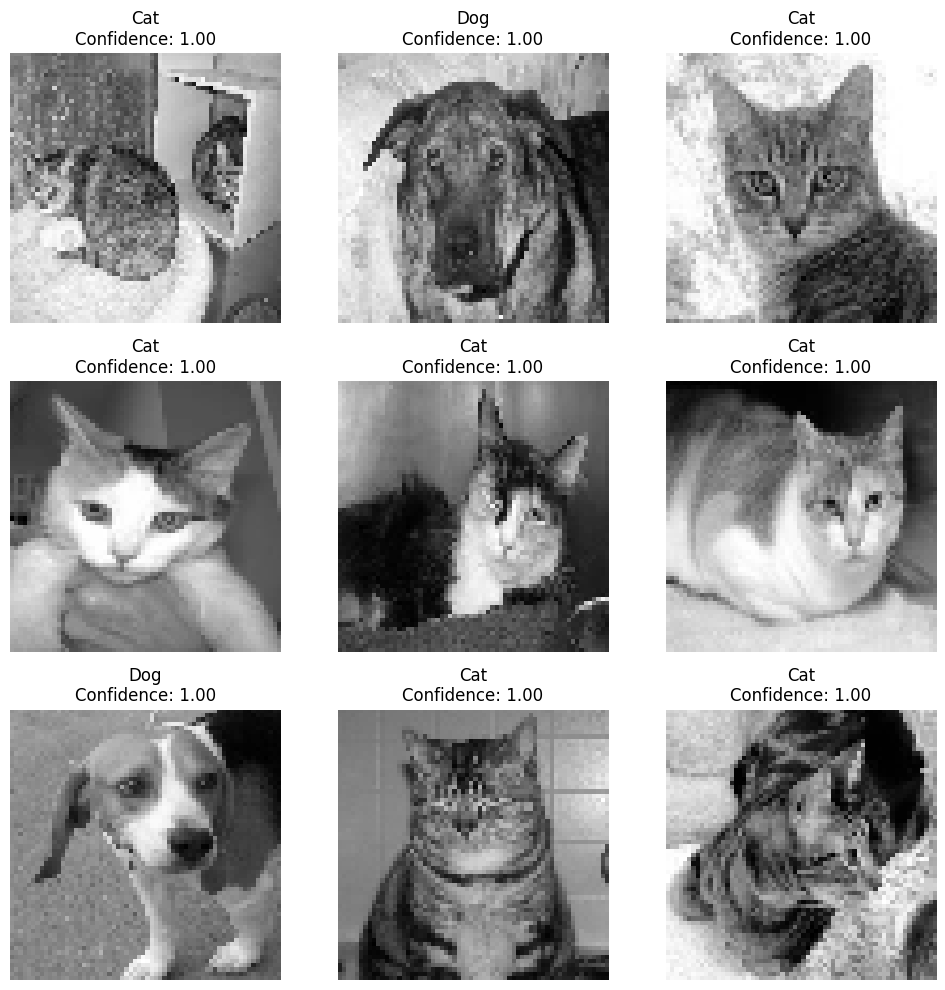

In [32]:
test_data = create_test_data()

# Prepare test images
X_test = np.array([i[0] for i in test_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test = X_test / 255.0  # normalize

# Run predictions
predictions = model.predict(X_test)

# Convert probabilities to labels
predicted_labels = (predictions > 0.5).astype(int)

# Show some sample predictions
num_samples = 9
plt.figure(figsize=(10, 10))

for i in range(num_samples):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[i].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')

    label = "Dog" if predicted_labels[i][0] == 1 else "Cat"
    
    
    if label=="Dog":
        confidence = predictions[i][0]
    else:
        confidence = 1-predictions[i][0]
    

    plt.title(f"{label}\nConfidence: {confidence:.2f}")
    plt.axis("off")

plt.tight_layout()
plt.show()